# Creation of all plots in paper
This notebook do the following:
1. sync all files, stack all runs, save references
2. non-linear scale for chameleon
3. matter power spectrum


## Syncing
File are copied from `koios:/home/users/vrastil/GIT/FastSim-Jobs/output/` and saved to `/home/michal/Documents/GIT/FastSim/jobs/output/`

In [1]:
import os
os.system("gnome-terminal -e 'bash -c \"/home/michal/Documents/GIT/FastSim/jobs/KOIOS/sync.sh all\" '")

0

## Stack everything

In [2]:
import simpy.power as pwr
import simpy.data as dt
import simpy.plot as pt
from simpy.struct import *

from scipy import interpolate
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
in_dir = '/home/michal/Documents/GIT/FastSim/jobs/output/'
out_dir = '/home/michal/Documents/GIT/FastSim/report/clanek/'
stack_infos = dt.stack_all(in_dir=in_dir, verbose=False, return_stack=True)
results = Results(in_dir)
results.info()

Stacking group 26/26

CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 1000 Mpc/h  \phi_s = 1.0e-05  (lin)	num runs = 20
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 1000 Mpc/h  \phi_s = 1.0e-05  (nl) 	num runs = 4
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-06  (nl) 	num runs = 20
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05  (lin)	num runs = 99
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05  (nl) 	num runs = 24
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05  (lin)	num runs = 100
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-06  (lin)	num runs = 100
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05  (nl) 	num runs = 20
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-04  (nl) 	num runs = 20
CHI:  N_m = 256  N_M = 512  N_p = 256^3  L = 2000 Mpc/h  \phi_s = 1.0e-05  (lin)	num runs = 120
CHI:  N_m = 256  N_M = 512

## Non-linear scale for chameleon

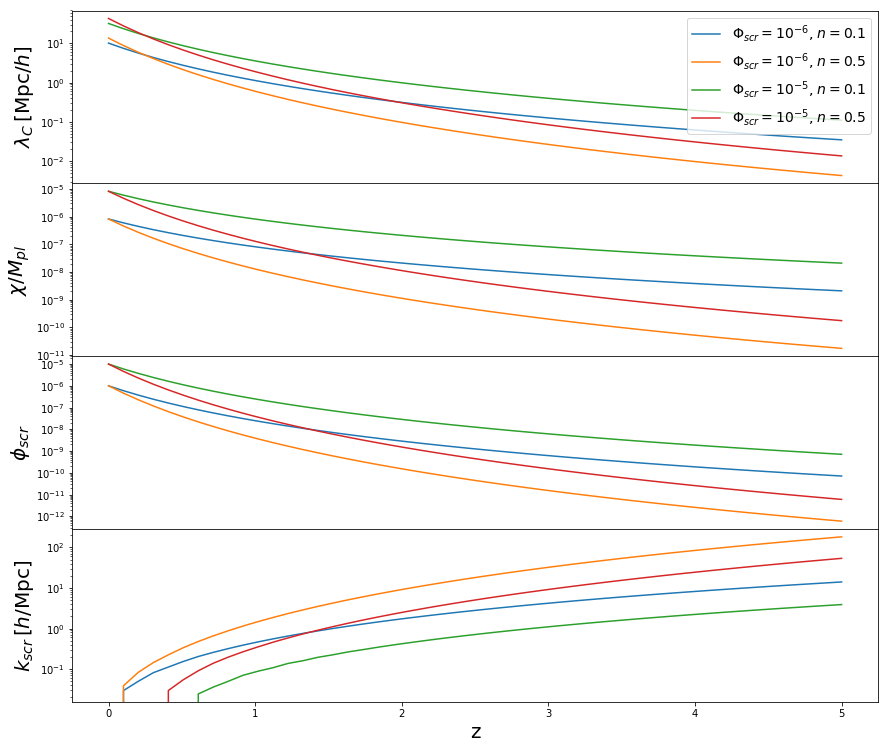

In [4]:
CHI_file = [si.file for si in stack_infos if si.app == 'CHI'][0]
n = [0.1,0.5]
phi = [10**(-6), 10**(-5)]
dt.plot_chi_wave_pot(a_file=CHI_file, outdir=out_dir, n=n, phi=phi)

## Matter Power Spectrum
1. stack runs of the same approximations together (increase resolution range)
2. plot power spectrum at $z=0$ with all approximation, cut to see difference at small scales
3. plot power spectrum relative difference at different redshifts, cut to $k_{nq}/2$
4. plot power spectrum suppresion at three different scales

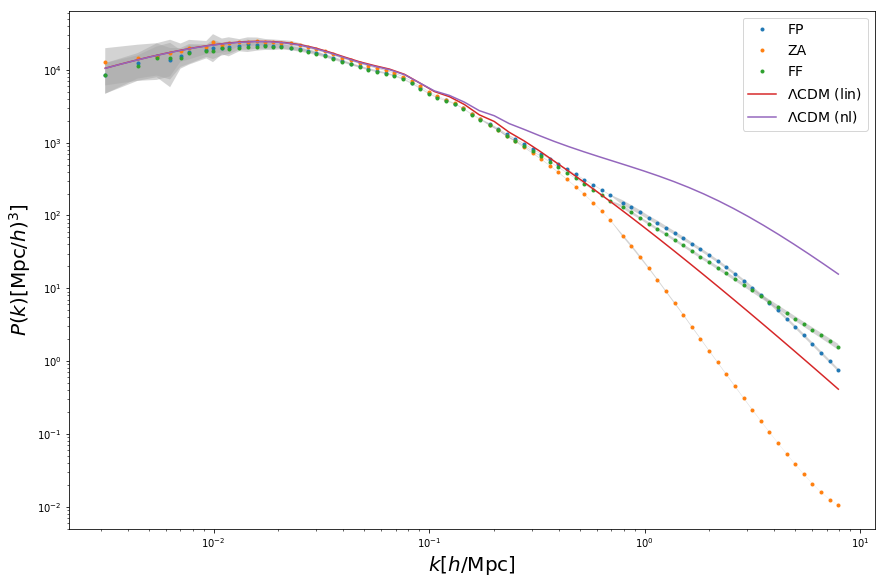

In [14]:
non_chi_stack_infos = results.get_subfiles(NM=1024, app_not='CHI')
dt.get_plot_mlt_pk_broad(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec/', z=0)

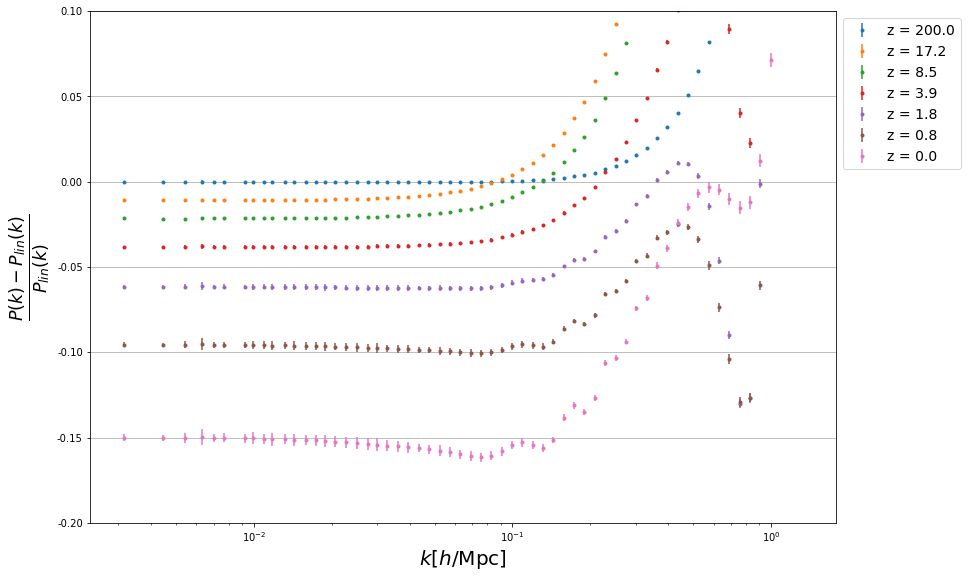

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


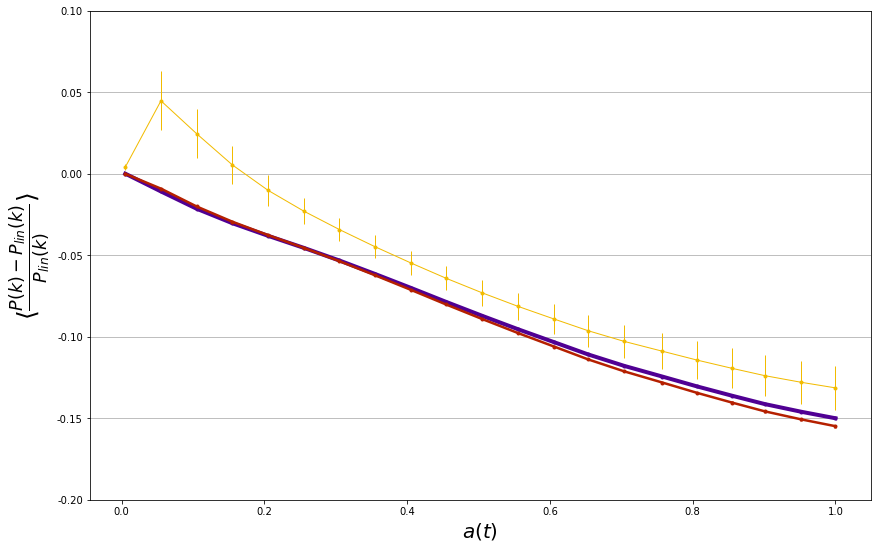

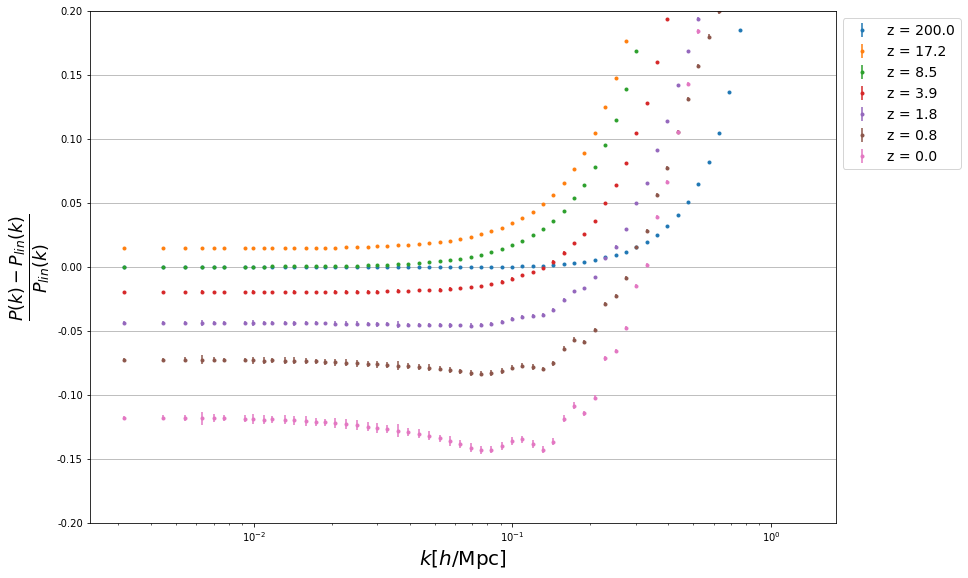

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


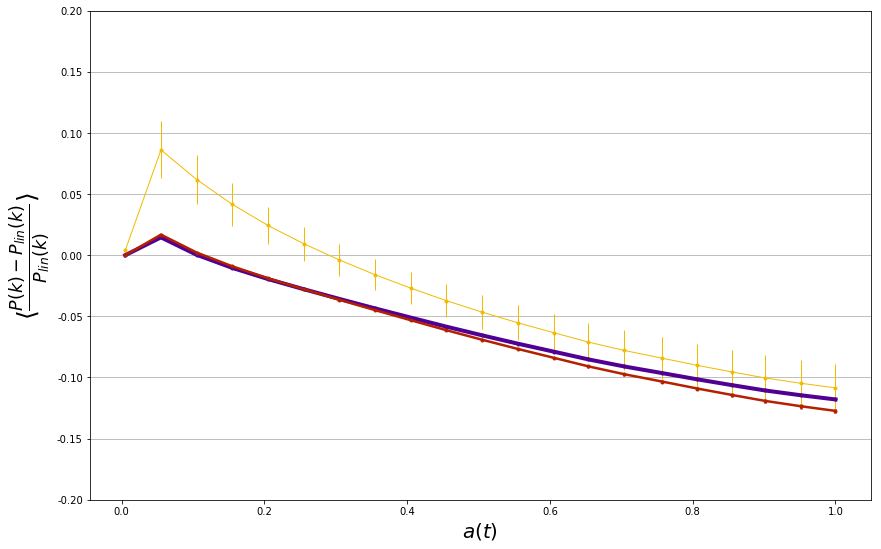

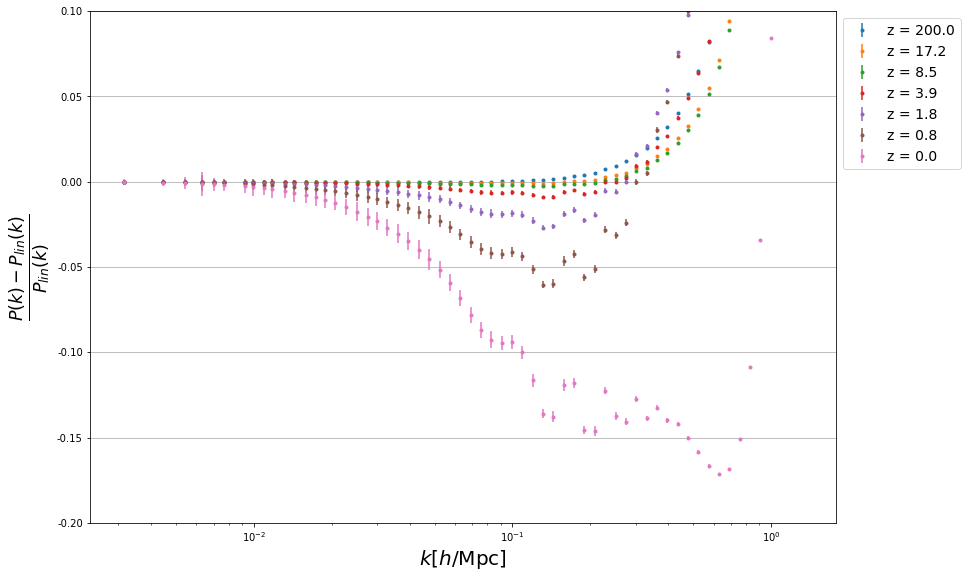

Large-scale: 0.0031,0.0031
Medium-scale: 0.0276,0.0276
Small-scale: 0.1439,0.1439


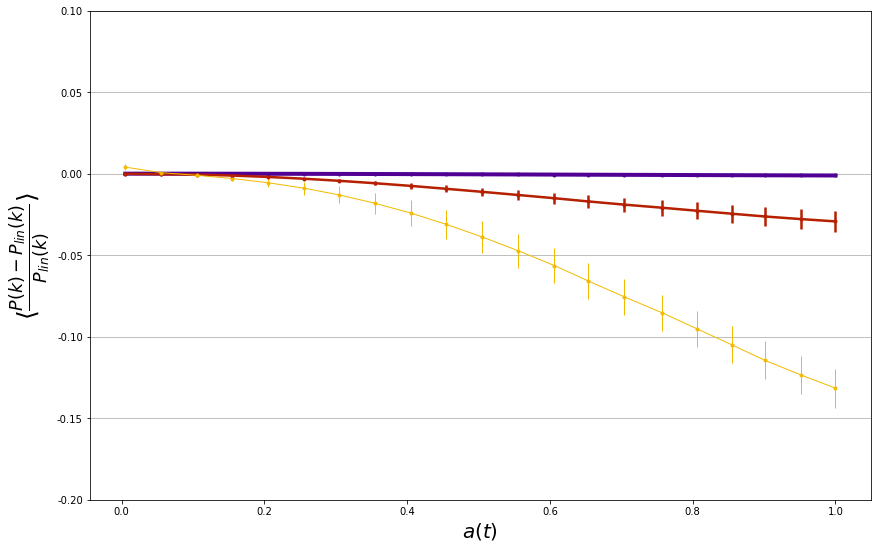

In [15]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
for a_sim_info in non_chi_stack_infos:
    # data
    zs, files = dt.try_get_zs_files(a_sim_info, "pwr_diff", '*input*')
    a = [1./(z+1.) for z in zs if z != 'init']
    data_list = [np.transpose(np.loadtxt(a_file)) for a_file in files]
    supp = dt.load_k_supp(files, a_sim_info.k_nyquist["particle"], a_sim_info=a_sim_info, a=a)
    
    # plots -- diff, supp 
    pt.plot_pwr_spec_diff_from_data(data_list, zs, a_sim_info, out_dir=out_dir + 'pwr_spec/', show_scales=False,
                                 ext_title='init', show=True, add_app=True, max_nyquist=True)
    
    
    pt.plot_supp_lms(supp, a, a_sim_info, out_dir=out_dir + 'pwr_spec/', show=True, add_app=True, scale_in_leg=False)
    
    

## Effective redshift
1. get $a_{eff}$ for each (non-chi) stack_info
2. plot both $P(k)$--type and $\sigma_R$--type
3. plot growth rate $f$

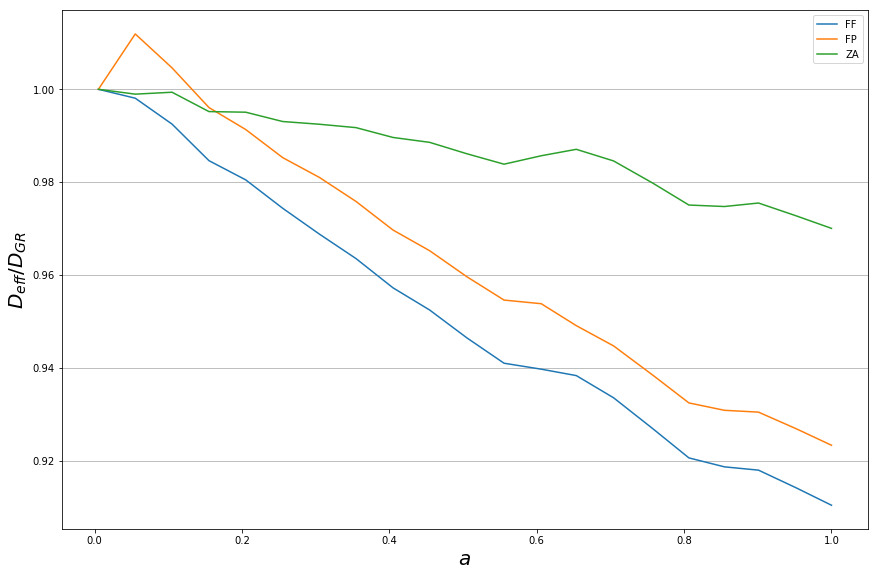

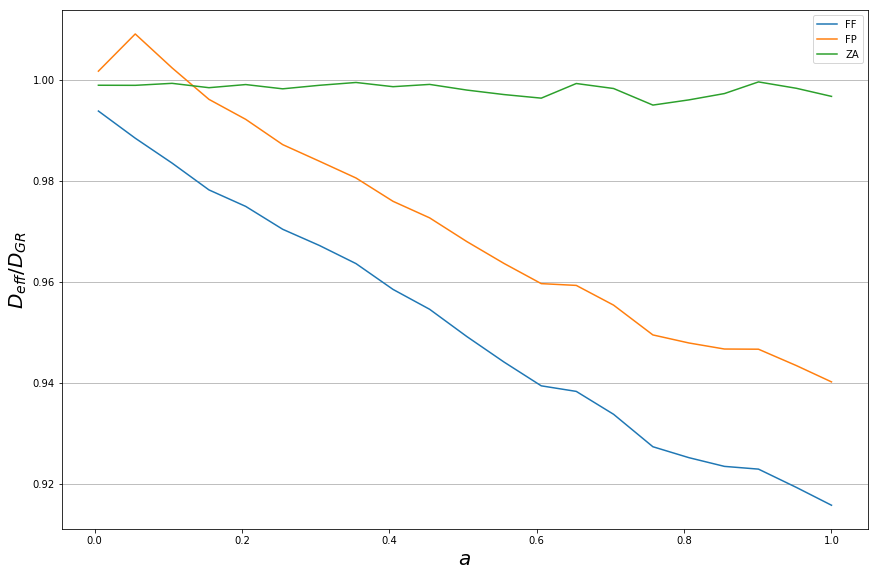

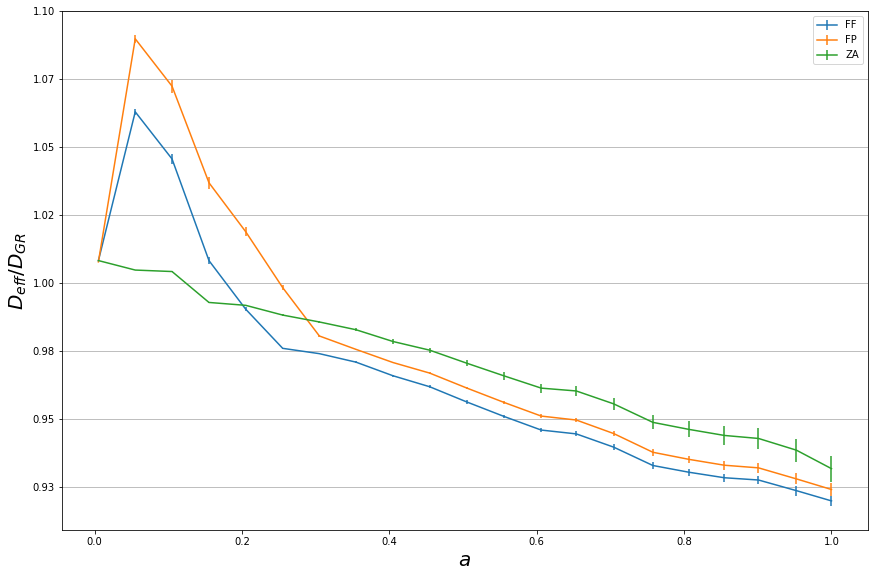

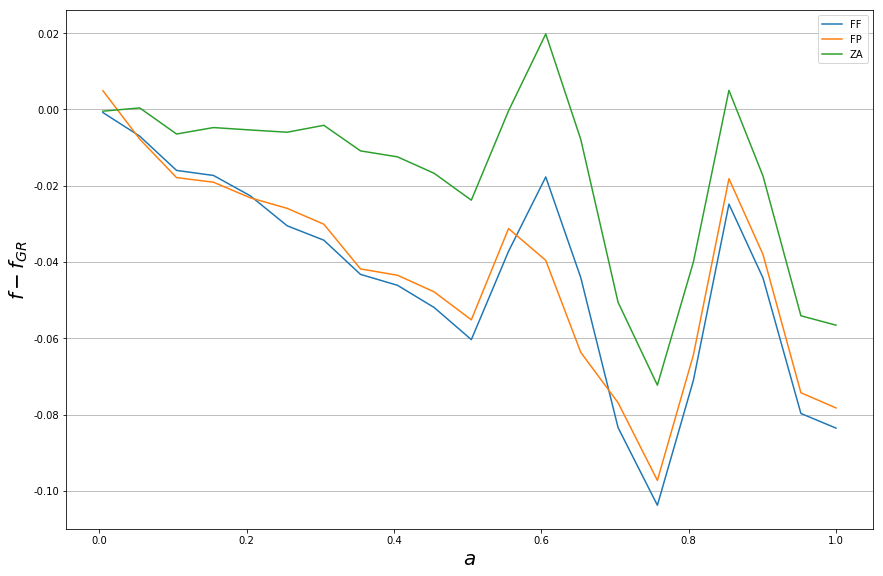

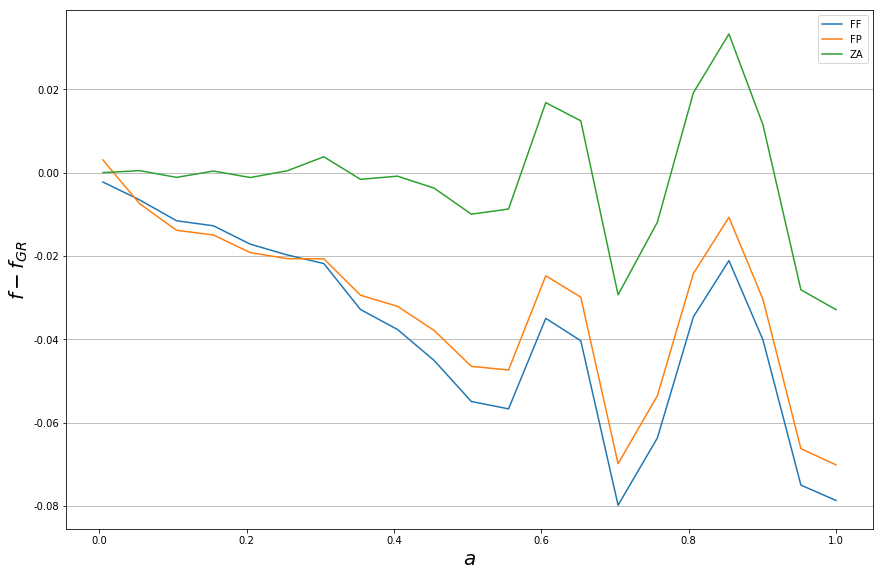

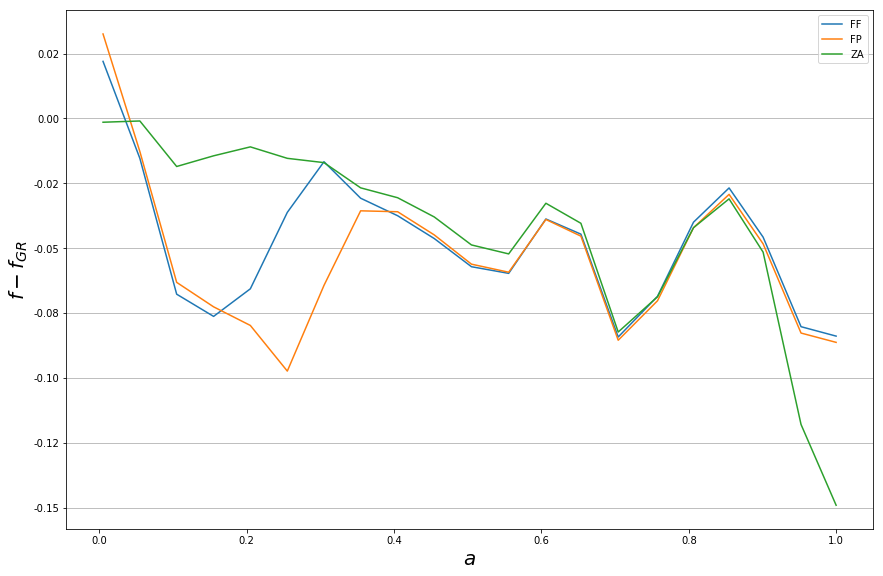

In [18]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')
for si in non_chi_stack_infos:
    dt.load_a_eff(si)
pt.plot_eff_time(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="all", show=True)
pt.plot_eff_growth_rate(non_chi_stack_infos, out_dir=out_dir + 'z_eff/', a_eff_type="all", show=True)

## Non-linear matter power spectrum
1. relative difference -- with effective redshift $z_{eff}$
2. relative difference (map)

FF:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 100$ Mpc/h  


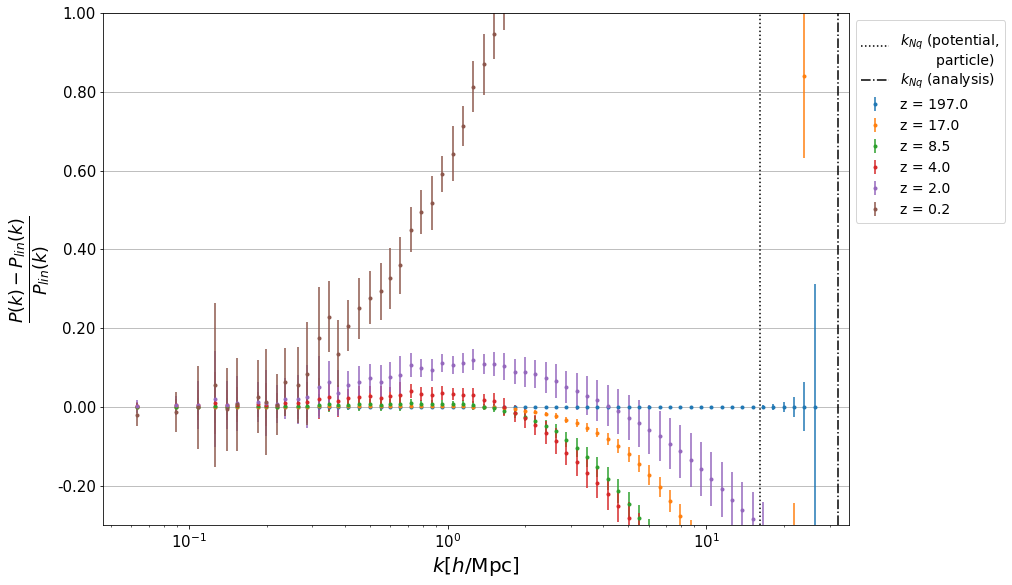

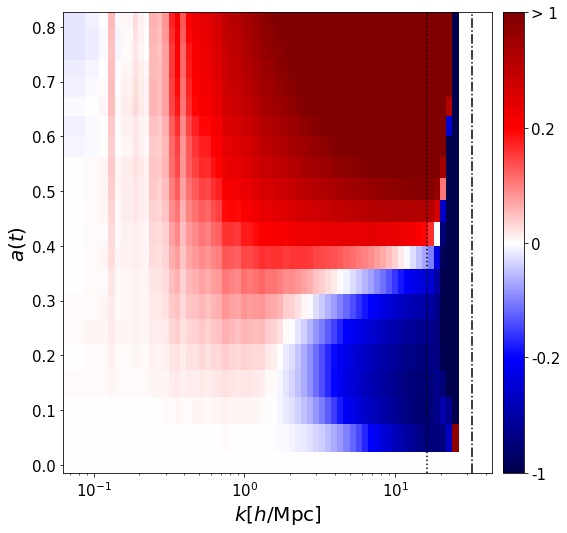

FF:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 2000$ Mpc/h  


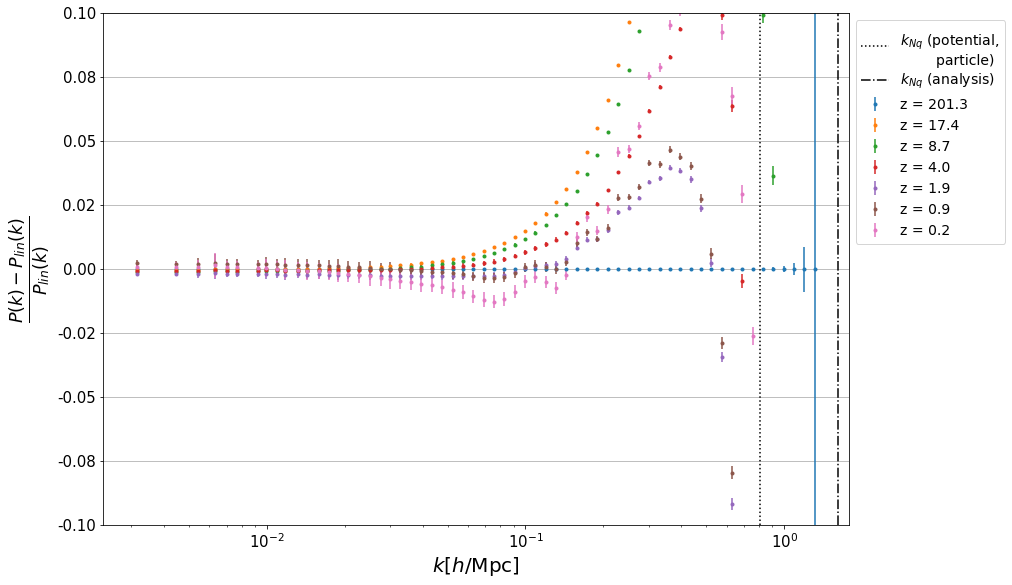

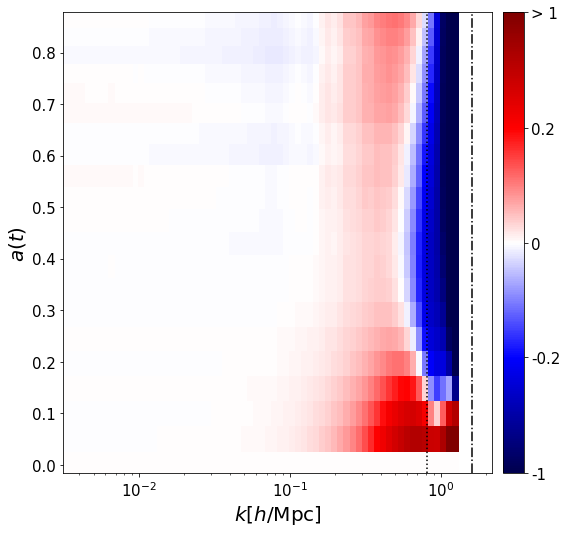

FF:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 500$ Mpc/h  


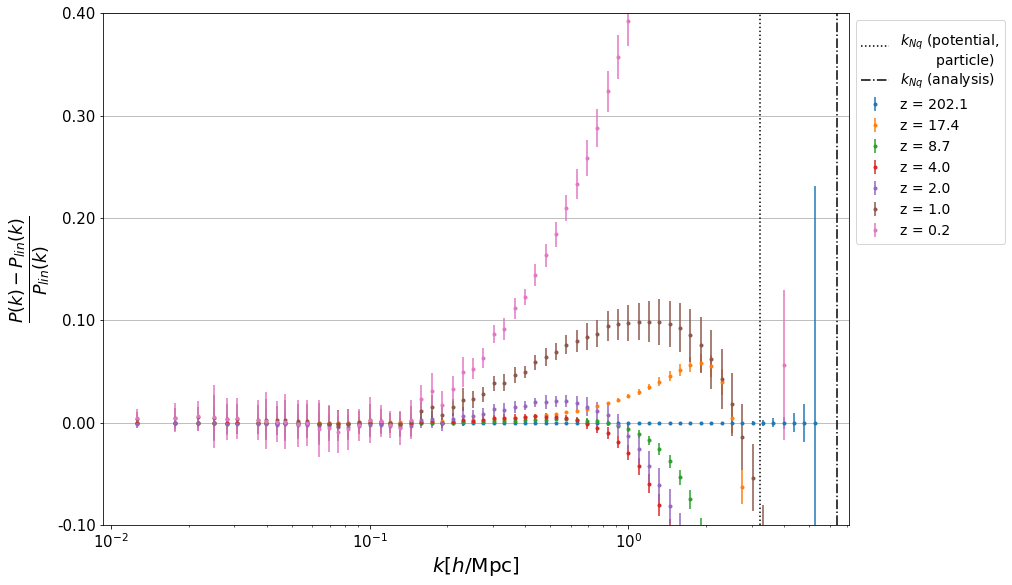

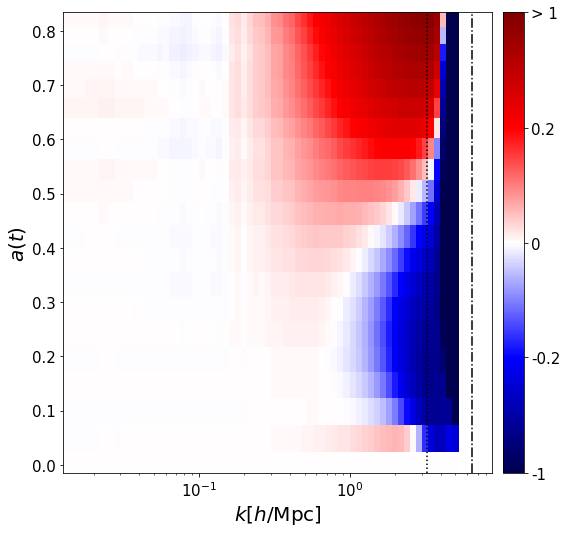

FP:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 100$ Mpc/h  


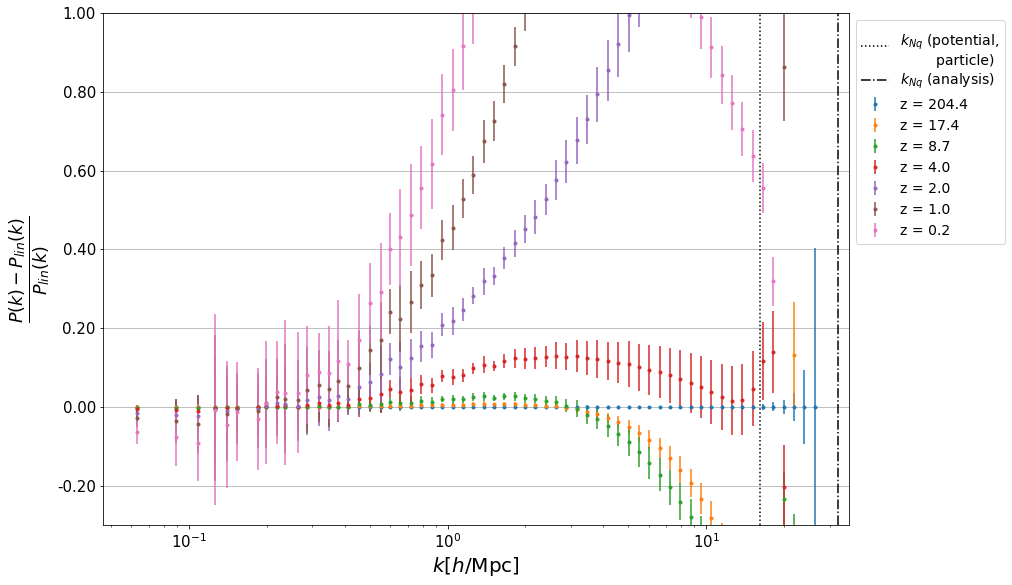

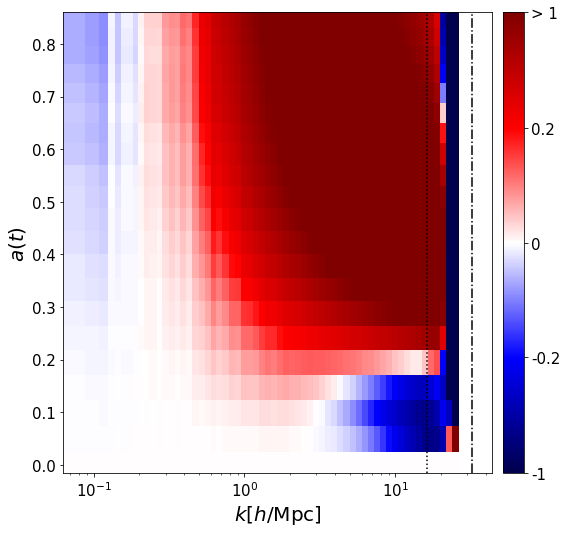

FP:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 500$ Mpc/h  


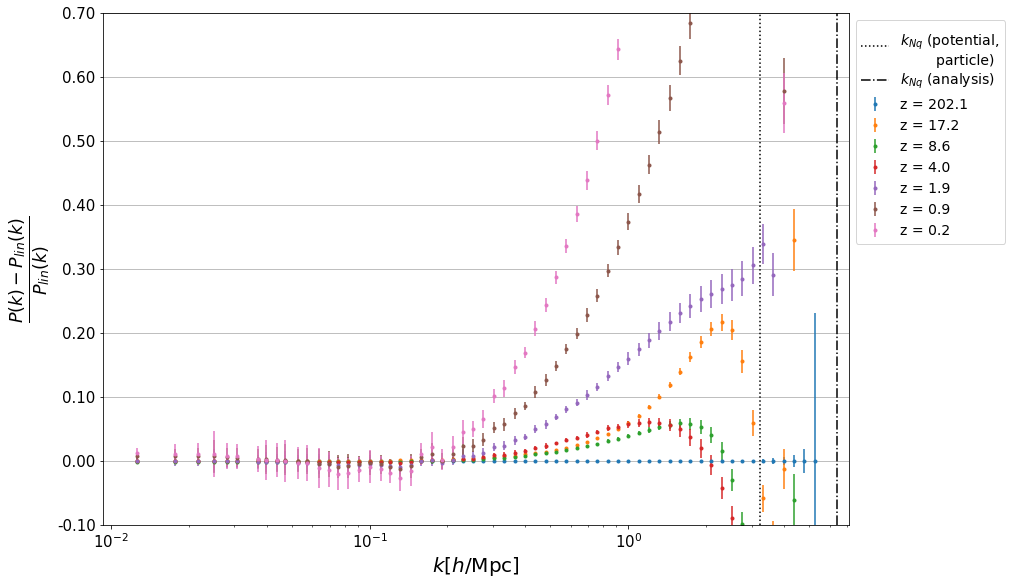

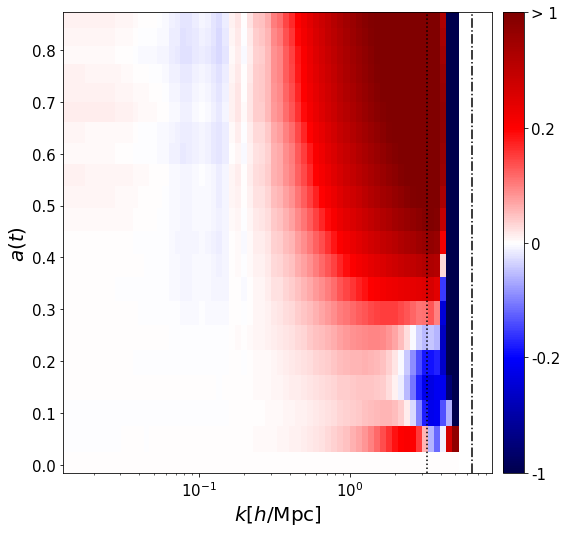

FP:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 2000$ Mpc/h  


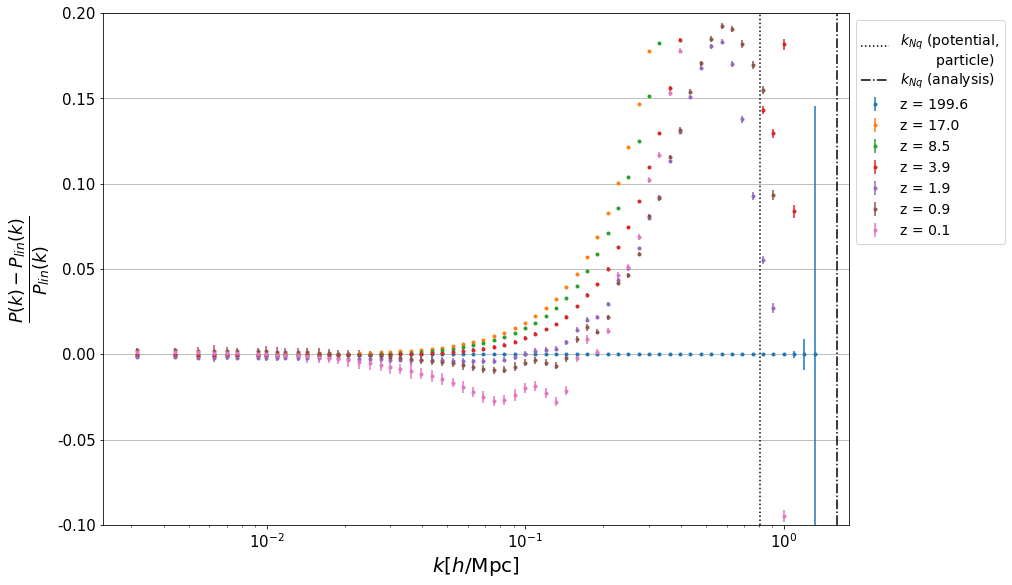

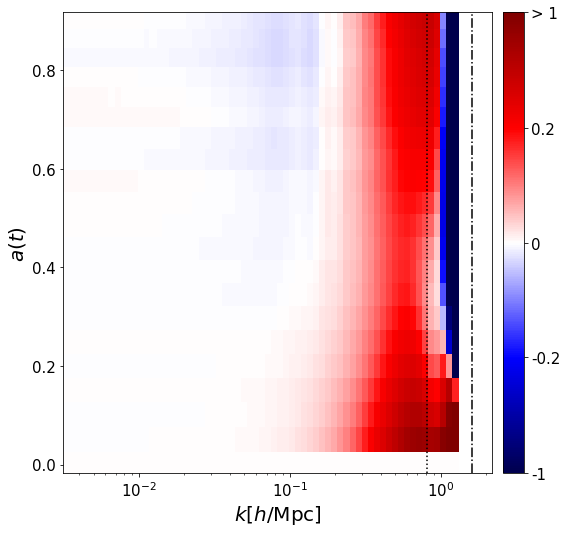

ZA:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 100$ Mpc/h  


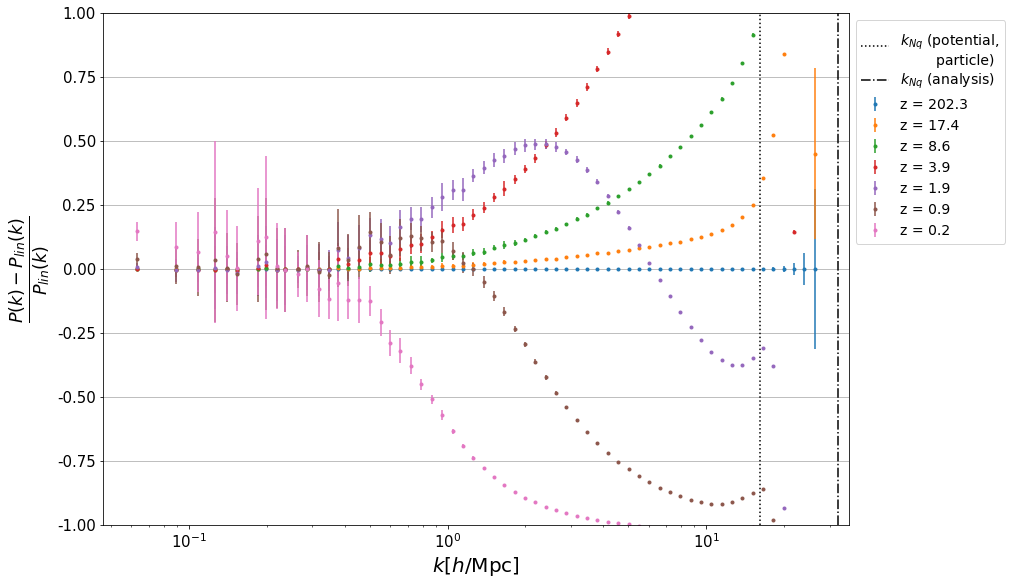

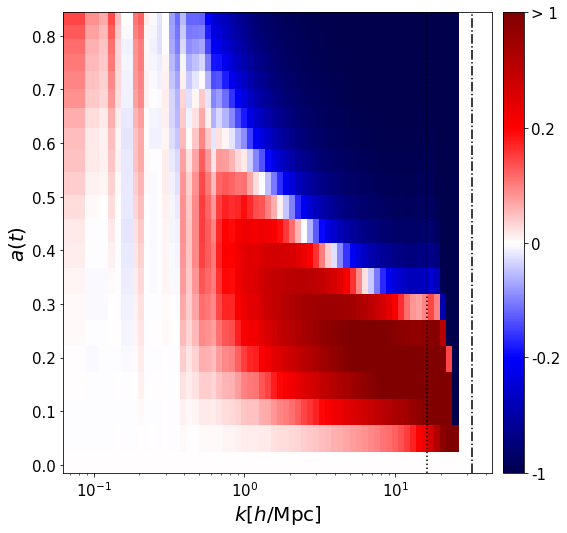

ZA:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 2000$ Mpc/h  


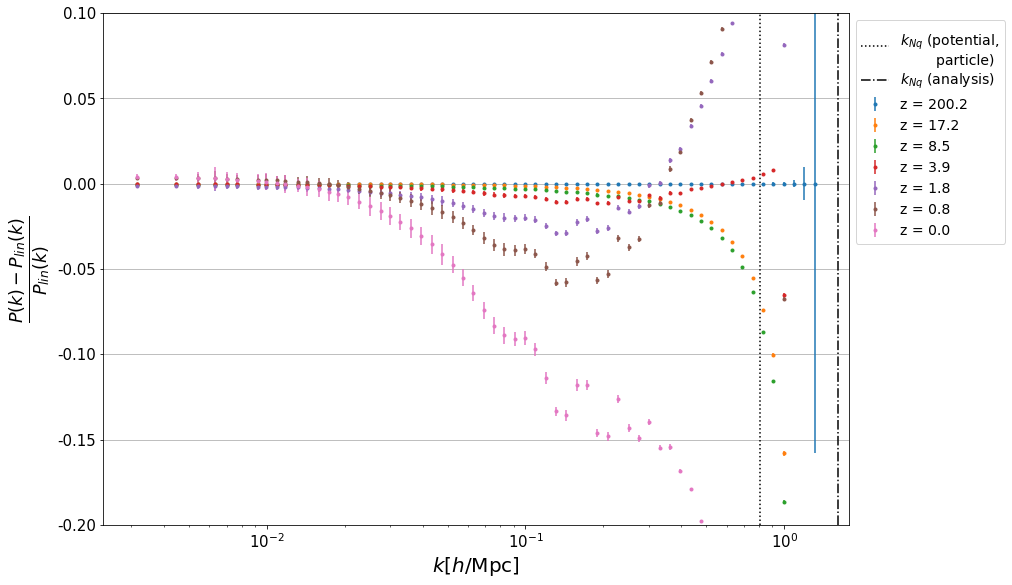

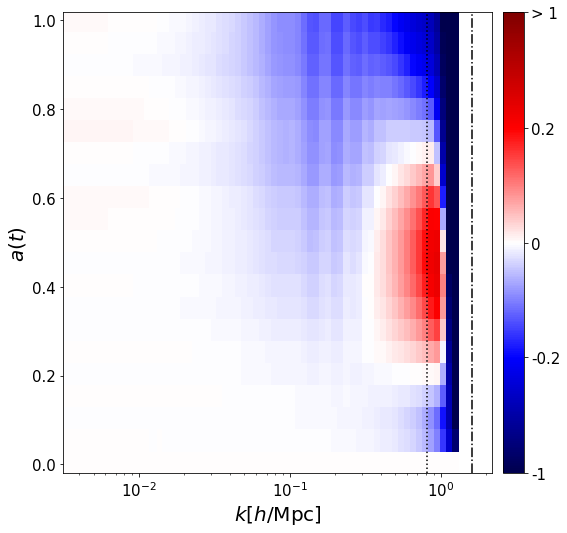

ZA:  $N_m = 512$  $N_M = 1024$  $N_p = 512^3$  $L = 500$ Mpc/h  


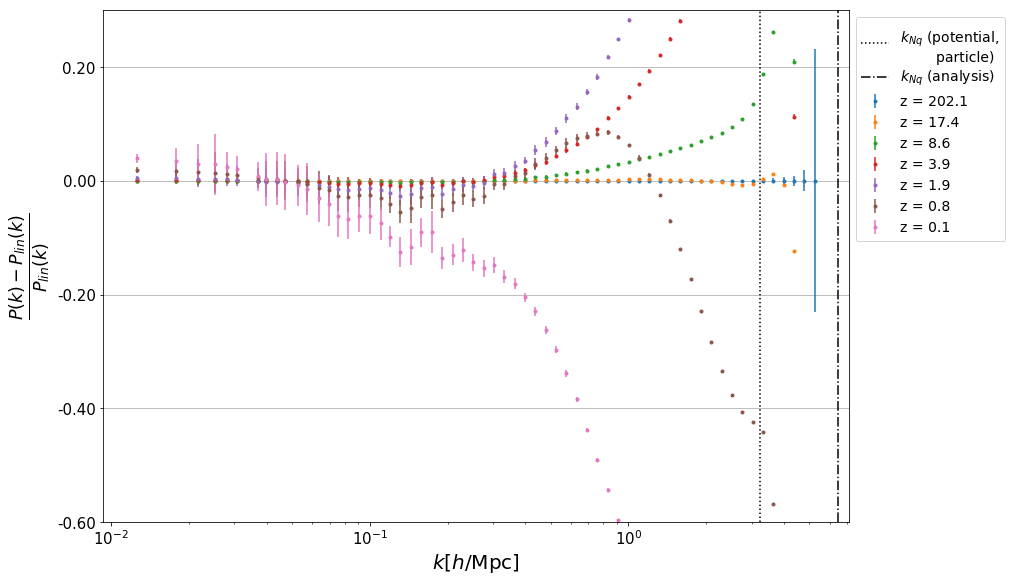

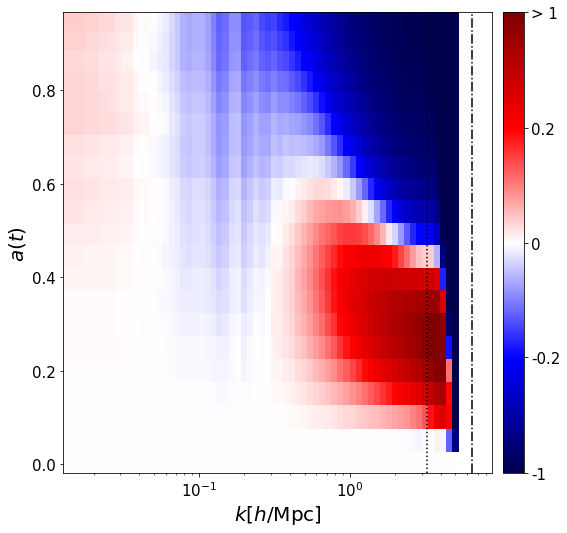

In [38]:
non_chi_stack_infos = results.get_subfiles(NM=1024,  app_not='CHI')
for si in non_chi_stack_infos:
    print si.info_tr()
    zs, data_array = dt.transform_supp_data_to_z_eff(si)
    pt.plot_pwr_spec_diff_from_data(data_array, zs, si, show_scales=False, save=False, show=True, use_z_eff=True)
    pt.plot_pwr_spec_diff_map_from_data(data_array, zs, si, save=False, show=True, use_z_eff=True)

## Stacking across multiple boxes
1. stack simulations across different runs (different box sizes)
2. use effective redshift
3. plot power spectrum difference / map

FP


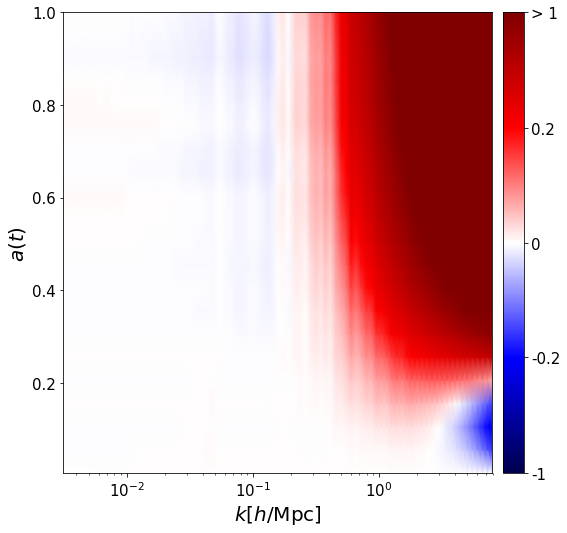

ZA


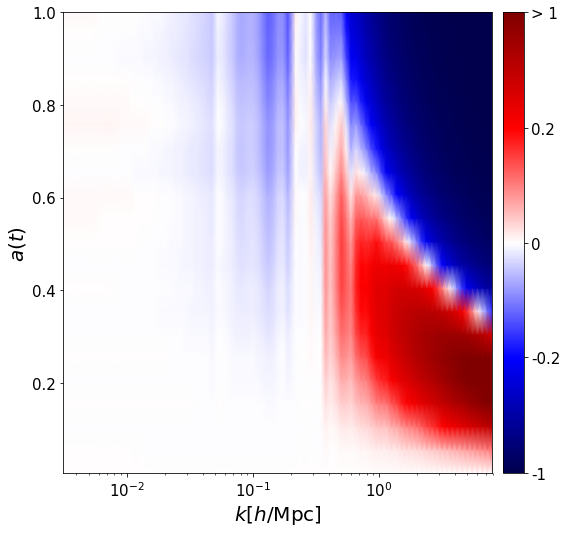

FF


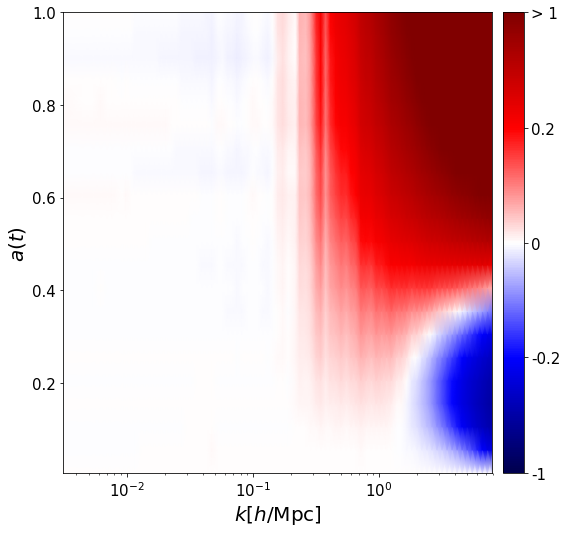

In [83]:
non_chi_stack_infos = results.get_subfiles(NM=1024, app_not='CHI')
dt.get_plot_mlt_pk_diff_broad(non_chi_stack_infos, out_dir=out_dir + 'pwr_spec_nl/')

## Correlation function
1. simple correlation function (all approximation)
2. correlation function difference (all approximation)
3. correlation function peak amplitude and location (with time)

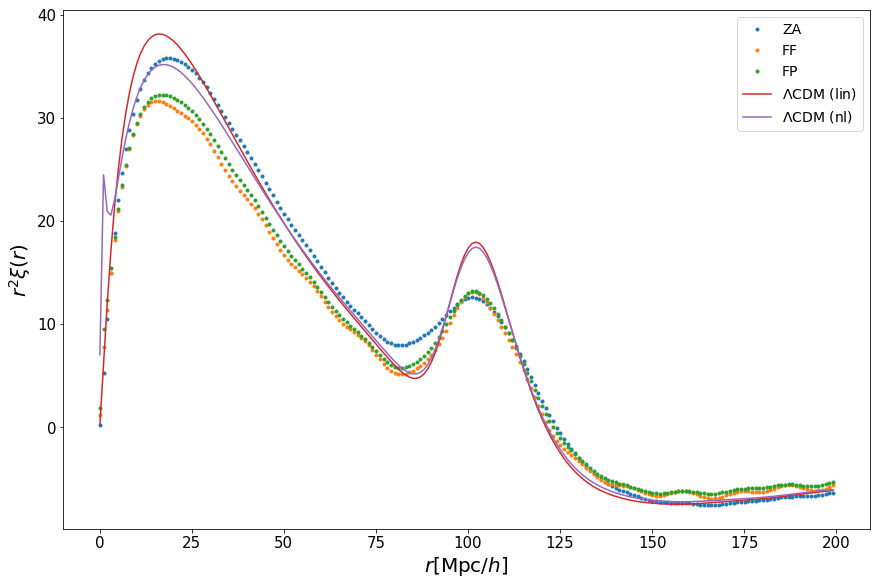

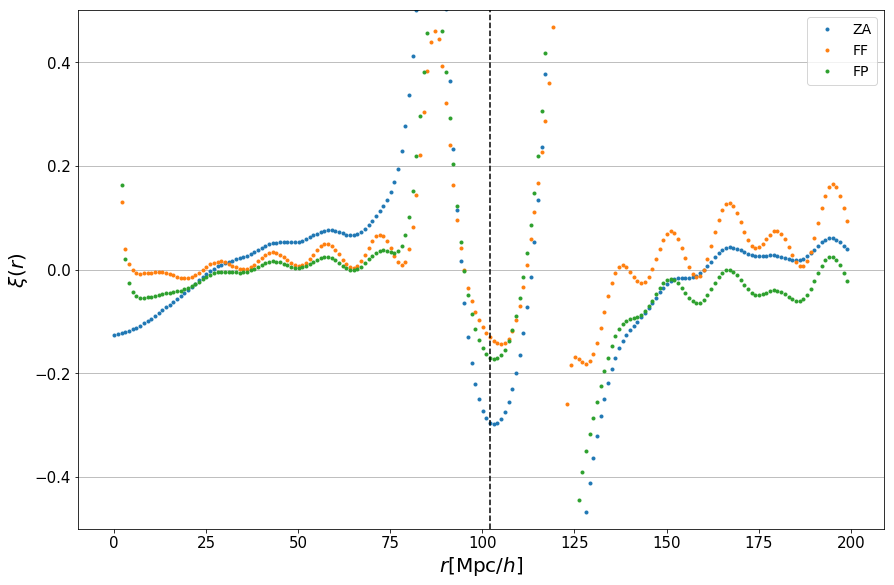

In [163]:
non_chi_stack_infos = results.get_subfiles(NM=1024, L=2000, app_not='CHI')

# dt.reinit_data(non_chi_stack_infos)
# for si in non_chi_stack_infos:
#     print si.data["corr_func"]["zs"]

dt.corr_func_comp(sim_infos=non_chi_stack_infos, outdir=out_dir + 'corr_func/', z=0)